In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-kymograms/final kymograms cropped/functional/552_crop6.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/267_crop16.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/50_crop12.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/405_crop11.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/598_crop9.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/435_crop2.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/435_crop14.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/373_crop8.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/175_crop13.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/107_crop6.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/72_crop15.png
/kaggle/input/final-kymograms/final kymograms cropped/functional/173_crop34.png
/kaggle/input/final-kymograms/final kymograms c

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os, shutil, random, time, copy
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
from pathlib import Path
import shutil, os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict

src_dir = Path("/kaggle/input/final-kymograms/final kymograms cropped")
dst_dir = Path("/kaggle/working/binary_split")

# Step 1: Map 3-class labels to binary
label_map = {
    'healthy': 'healthy',
    'functional': 'unhealthy',
    'organic': 'unhealthy'
}

# Step 2: Load and label all images
all_images = []
for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    if cls_dir.is_dir():
        mapped_label = label_map[cls]
        for img_path in cls_dir.glob("*.png"):
            all_images.append((img_path, mapped_label))

# Step 3: Split 15% test set
labels = [label for _, label in all_images]
trainval, test = train_test_split(all_images, test_size=0.15, stratify=labels, random_state=42)

# Step 4: Split 85% trainval into 70/15 split (82.35% train and 17.65% val of trainval)
trainval_labels = [label for _, label in trainval]
train, val = train_test_split(trainval, test_size=0.1765, stratify=trainval_labels, random_state=42)

# Step 5: Copy to new directory
def copy_images(data, split_name):
    for img_path, label in data:
        dest_dir = dst_dir / split_name / label
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, dest_dir / img_path.name)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

print(f"Data split complete:\n- Train: {len(train)}\n- Validation: {len(val)}\n- Test: {len(test)}")

# Step 6: Oversample to balance training set
train_dir = dst_dir / "train"
class_images = defaultdict(list)

for cls in os.listdir(train_dir):
    cls_path = train_dir / cls
    class_images[cls] = list(cls_path.glob("*.png"))

# Determine max class count
target_count = max(len(images) for images in class_images.values())

# Oversample
for cls, images in class_images.items():
    if len(images) < target_count:
        to_add = random.choices(images, k=target_count - len(images))
        for i, img_path in enumerate(to_add):
            new_name = img_path.stem + f"_dup{i}" + img_path.suffix
            shutil.copy(img_path, img_path.parent / new_name)

print(f"Training set balanced using random oversampling (~{target_count} per class)")

Data split complete:
- Train: 6926
- Validation: 1485
- Test: 1485
Training set balanced using random oversampling (~4353 per class)


In [7]:

# ===========================
# Binary Classification Training
# ===========================

# Paths
train_dir = "/kaggle/working/binary_split/train"
val_dir = "/kaggle/working/binary_split/val"
test_dir = "/kaggle/working/binary_split/test"

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load data
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and modify InceptionV3
weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights, aux_logits=True)

# Modify classifier for binary classification
model.AuxLogits.fc = nn.Linear(768, 1)
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 1)
)

model = model.to(device)

# Binary class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.targets),
    y=train_data.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss & optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 30
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs, aux_outputs = model(images)

        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels.byte()).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.byte()).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model_binary_inceptionv3.pth")


    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {int(elapsed)}s - "
          f"accuracy: {train_acc:.4f} - loss: {train_loss:.4f} - "
          f"val_accuracy: {val_acc:.4f} - val_loss: {val_loss:.4f}")

# Load best model
model.load_state_dict(torch.load("best_model_binary_inceptionv3.pth"))

Epoch 1/30 - 202s - accuracy: 0.8177 - loss: 0.5164 - val_accuracy: 0.9529 - val_loss: 0.1219
Epoch 2/30 - 201s - accuracy: 0.9609 - loss: 0.1568 - val_accuracy: 0.9771 - val_loss: 0.0581
Epoch 3/30 - 200s - accuracy: 0.9752 - loss: 0.0942 - val_accuracy: 0.9960 - val_loss: 0.0200
Epoch 4/30 - 200s - accuracy: 0.9856 - loss: 0.0713 - val_accuracy: 0.9899 - val_loss: 0.0424
Epoch 5/30 - 200s - accuracy: 0.9853 - loss: 0.0700 - val_accuracy: 0.9798 - val_loss: 0.0547
Epoch 6/30 - 201s - accuracy: 0.9830 - loss: 0.0844 - val_accuracy: 0.9886 - val_loss: 0.0386
Epoch 7/30 - 201s - accuracy: 0.9870 - loss: 0.0587 - val_accuracy: 0.9973 - val_loss: 0.0120
Epoch 8/30 - 201s - accuracy: 0.9964 - loss: 0.0423 - val_accuracy: 0.9919 - val_loss: 0.0317
Epoch 9/30 - 201s - accuracy: 0.9926 - loss: 0.0343 - val_accuracy: 0.9966 - val_loss: 0.0138
Epoch 10/30 - 201s - accuracy: 0.9952 - loss: 0.0406 - val_accuracy: 0.9980 - val_loss: 0.0071
Epoch 11/30 - 201s - accuracy: 0.9892 - loss: 0.0469 - val_

/tmp/ipykernel_31/682069746.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_binary_inceptionv3.pth"))


<All keys matched successfully>


Test Performance of Binary InceptionV3 Classifier
Metrics             Value
----------------------------------------
Class 0
F1 Score (%)           99.95
Precision (%)          99.89
Recall (%)            100.00
Sensitivity (%)       100.00
Specificity (%)        99.82
----------------------------------------
Class 1
F1 Score (%)           99.91
Precision (%)         100.00
Recall (%)             99.82
Sensitivity (%)        99.82
Specificity (%)       100.00
----------------------------------------
Overall Accuracy (%)   99.93


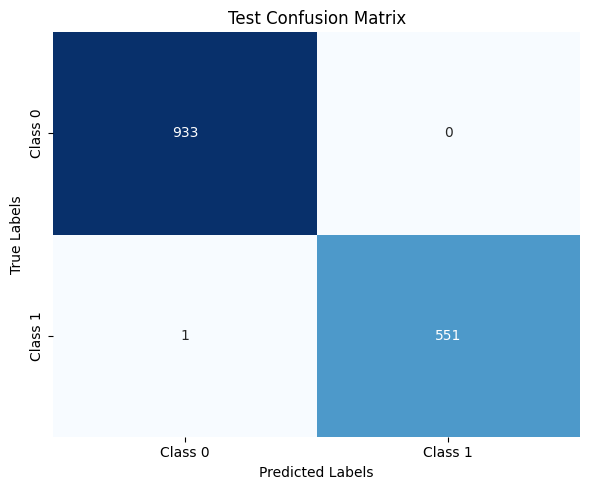

In [12]:
# ===========================
# Evaluation on Test Set
# ===========================
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score
model.eval()

test_y_true = []
test_y_pred = []
test_y_probs = []

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)

        outputs = model(test_x)
        probs = torch.sigmoid(outputs)  # For BCEWithLogitsLoss

        preds = probs > 0.5  # Binary classification threshold

        test_y_true.extend(test_y.cpu().numpy())
        test_y_pred.extend(preds.cpu().numpy())
        test_y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
test_y_true = np.array(test_y_true)
test_y_pred = np.array(test_y_pred).astype(int)
test_y_probs = np.array(test_y_probs)
class_names = [f"Class {int(c)}" for c in np.unique(test_y_true)]


# AUC Score
test_auc = roc_auc_score(test_y_true, test_y_probs) * 100

# Classification report
test_report = classification_report(test_y_true, test_y_pred, target_names=class_names, output_dict=True)

# Confusion matrix
test_conf_matrix = confusion_matrix(test_y_true, test_y_pred)

# Sensitivity and Specificity
test_sensitivity = []
test_specificity = []
n_classes = 2  # For binary classification: healthy vs unhealthy

for i in range(n_classes):
    TP = test_conf_matrix[i, i]
    FN = test_conf_matrix[i].sum() - TP
    FP = test_conf_matrix[:, i].sum() - TP
    TN = test_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    test_sensitivity.append(sensitivity)
    test_specificity.append(specificity)

# Accuracy
test_acc = accuracy_score(test_y_true, test_y_pred) * 100

# Print Test Report
print("\nTest Performance of Binary InceptionV3 Classifier")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'F1 Score (%)':<20}{test_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{test_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{test_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{test_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{test_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{test_acc:>8.2f}")



# Confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


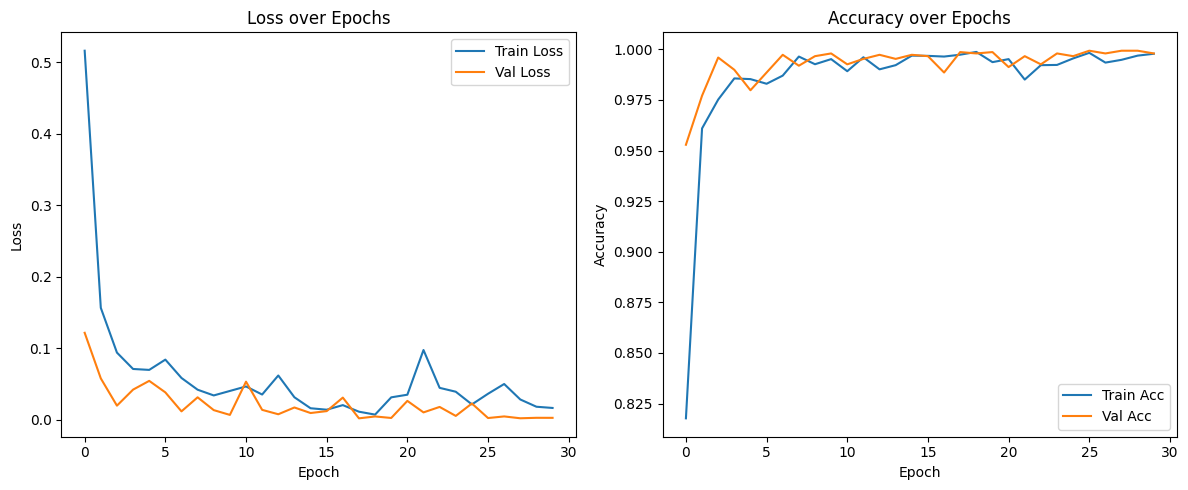

In [13]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



Validation Performance of Binary InceptionV3 Classifier
Metrics             Value
----------------------------------------
Class 0
F1 Score (%)           99.95
Precision (%)          99.89
Recall (%)            100.00
Sensitivity (%)       100.00
Specificity (%)        99.82
----------------------------------------
Class 1
F1 Score (%)           99.91
Precision (%)         100.00
Recall (%)             99.82
Sensitivity (%)        99.82
Specificity (%)       100.00
----------------------------------------
Overall Accuracy (%)   99.93
AUC Score (%)         100.00


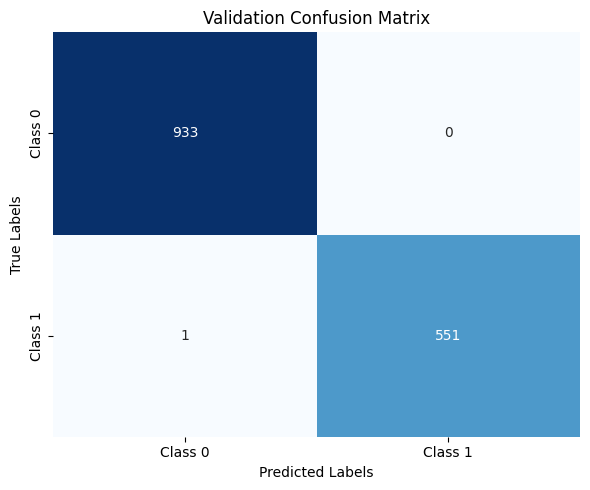

In [14]:
# ===========================
# Evaluation on Validation Set
# ===========================
model.eval()

val_y_true = []
val_y_pred = []
val_y_probs = []

with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        outputs = model(val_x)
        probs = torch.sigmoid(outputs)  # For BCEWithLogitsLoss

        preds = probs > 0.5  # Binary threshold

        val_y_true.extend(val_y.cpu().numpy())
        val_y_pred.extend(preds.cpu().numpy())
        val_y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
val_y_true = np.array(val_y_true)
val_y_pred = np.array(val_y_pred).astype(int)
val_y_probs = np.array(val_y_probs)

# AUC Score
val_auc = roc_auc_score(val_y_true, val_y_probs) * 100

# Classification Report
val_report = classification_report(val_y_true, val_y_pred, target_names=class_names, output_dict=True)

# Confusion Matrix
val_conf_matrix = confusion_matrix(val_y_true, val_y_pred)

# Sensitivity and Specificity
val_sensitivity = []
val_specificity = []

for i in range(n_classes):
    TP = val_conf_matrix[i, i]
    FN = val_conf_matrix[i].sum() - TP
    FP = val_conf_matrix[:, i].sum() - TP
    TN = val_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    val_sensitivity.append(sensitivity)
    val_specificity.append(specificity)

# Accuracy
val_acc = accuracy_score(val_y_true, val_y_pred) * 100

# Print Validation Report
print("\nValidation Performance of Binary InceptionV3 Classifier")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'F1 Score (%)':<20}{val_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{val_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{val_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{val_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{val_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{val_acc:>8.2f}")
print(f"{'AUC Score (%)':<20}{val_auc:>8.2f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

# Save history dictionary as CSV
history_df = pd.DataFrame(history)
history_df.to_csv("binary_inceptionv3_training_history.csv", index=False)


In [17]:
# Save test labels and probabilities for ROC and Accuracy
results_df = pd.DataFrame({
    "TrueLabel": test_y_true.flatten(),
    "PredictedProb": test_y_probs.flatten(),
    "PredictedLabel": test_y_pred.flatten()
})
results_df.to_csv("binary_inceptionv3_test_predictions.csv", index=False)
